## LSTM (Using Single Step Approach)

* Single-step approach predicts only the next step (t + delta t) and compares directly with actual values. 

* No feedback loop where predictions become inputs for the next step. 

* More precise evaluation since predictions are independently tested against y_test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load dataset
train_data = pd.read_csv('training_1.csv')
test_data = pd.read_csv('testing_1.csv')

# Normalize `IP Delay (ms)`
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

print(train_data.head())  # Check the normalized data


   SN  IP Delay (ms)  Normalized IP Delay
0   1      19.265890             0.609268
1   2      19.082069             0.572774
2   3      19.102097             0.576750
3   4      19.090891             0.574525
4   5      18.964052             0.549344


In [3]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Sequence of `sequence_length`
        y.append(data[i+sequence_length])   # Target value (next time step)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 10

# Prepare training sequences
train_values = train_data['Normalized IP Delay'].values
X_train, y_train = create_sequences(train_values, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Prepare testing sequences
test_values = test_data['Normalized IP Delay'].values
X_test, y_test = create_sequences(test_values, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (190, 10, 1)
y_train Shape: (190,)
X_test Shape: (540, 10, 1)
y_test Shape: (540,)


Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1762 - val_loss: 0.0065
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0526 - val_loss: 0.0294
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0353 - val_loss: 0.0080
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0227 - val_loss: 0.0042
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0296 - val_loss: 0.0062
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0338 - val_loss: 0.0025
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0282 - val_loss: 0.0012
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0247 - val_loss: 0.0022
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - val_loss: 6.0346e-04
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0149 - val_loss: 5.4076e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0135 - val_loss: 3.0681e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.

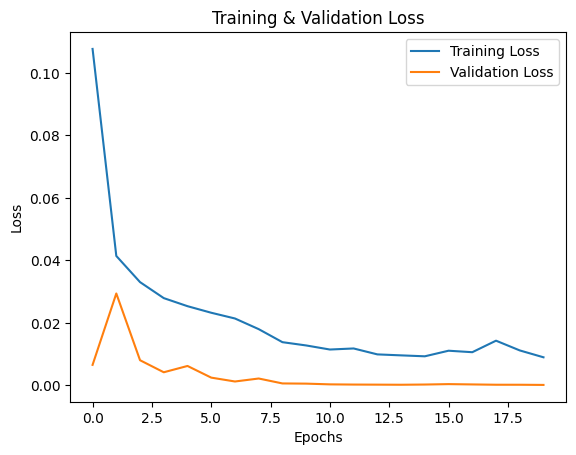

In [4]:
# Define model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)), 
    Dense(1)  # Single output for next step prediction
])

# Compile with optimized hyperparameters
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training progress
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
# Predict single-step delay for each sequence
single_step_predictions = model.predict(X_test)

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(single_step_predictions)

# Denormalize actual values
denormalized_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN 100 to 200
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 100) & (comparison_df['SN'] <= 200)]

#  Print filtered DataFrame
print(comparison_df_filtered)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
99   100              19.318819                 19.345379            0.026560
100  101              19.319057                 19.252075            0.066982
101  102              19.184828                 19.202824            0.017996
102  103              19.212008                 19.111891            0.100117
103  104              19.086123                 19.075891            0.010231
..   ...                    ...                       ...                 ...
195  196              18.313169                 18.342142            0.028973
196  197              18.329859                 18.248472            0.081387
197  198              18.321037                 18.203190            0.117847
198  199              18.179893                 18.171989            0.007904
199  200              18.197060                 18.095119            0.101940

[101 rows x 4 columns]


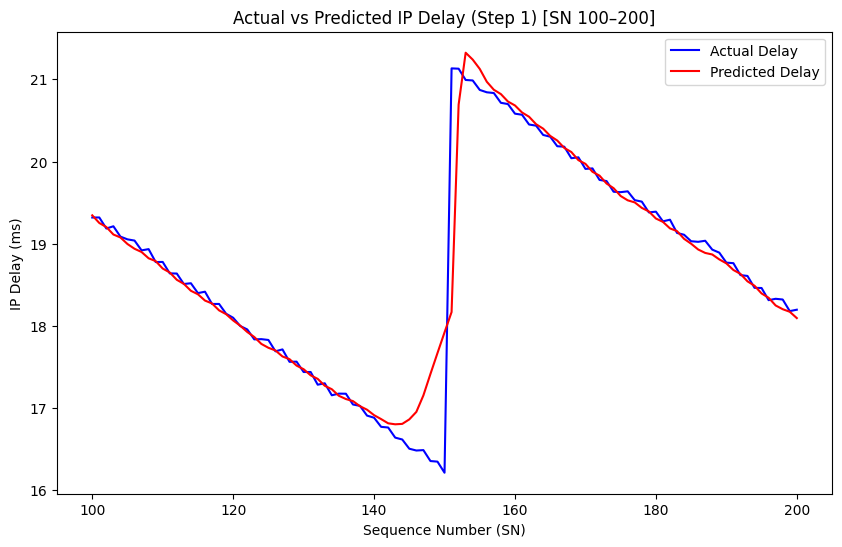

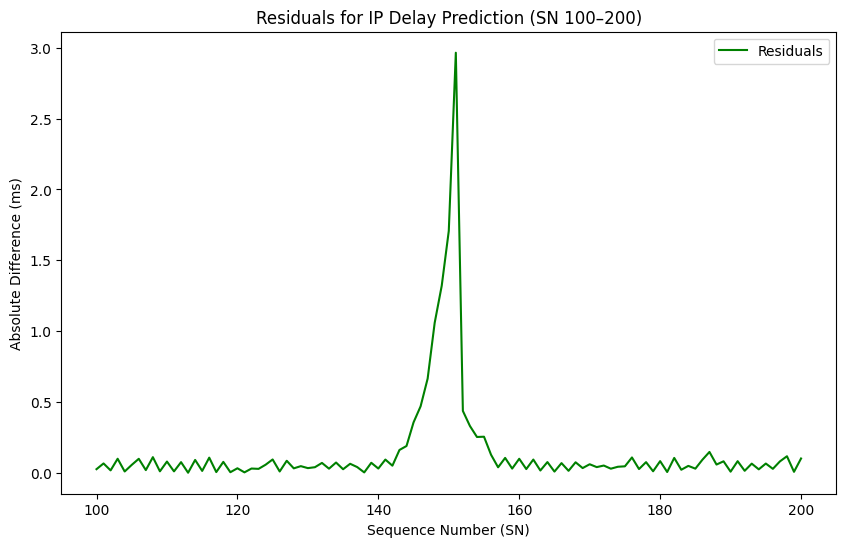

In [6]:

#  Plot actual vs predicted (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay (Step 1) [SN 100–200]')
plt.legend()
plt.show()

#  Plot residuals (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals', color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction (SN 100–200)')
plt.legend()

## Single step approch with multiple outputs           (Sequence-to-Sequence Approach)


* Predict the next k timesteps (e.g., t+1 to t+5) from one input sequence [t0...tN]
* No Feedback loop is used

Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.2509 - val_loss: 0.0078
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0758 - val_loss: 0.0257
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0552 - val_loss: 0.0162
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0551 - val_loss: 0.0101
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0472 - val_loss: 0.0108
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0405 - val_loss: 0.0034
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0238 - val_loss: 0.0026
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0180 - val_loss: 0.0012
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0178 - val_loss: 8.3718e-04
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0218 - val_loss: 0.0020
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204 - val_loss: 9.1119e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0248 

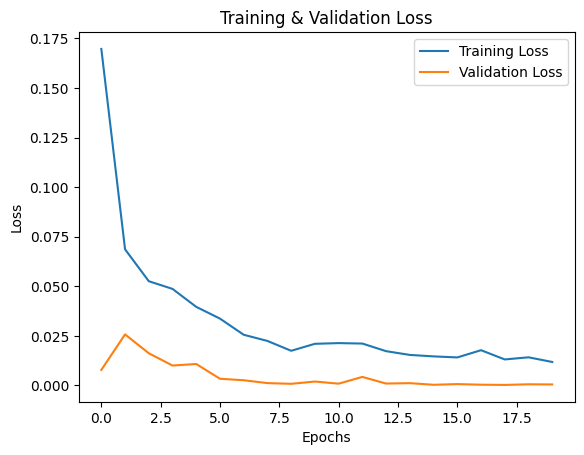

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
99   100              19.318819                 19.287256            0.031563
100  101              19.319057                 19.208059            0.110998
101  102              19.184828                 19.148777            0.036051
102  103              19.212008                 19.069462            0.142546
103  104              19.086123                 19.017426            0.068697
..   ...                    ...                       ...                 ...
195  196              18.313169                 18.277925            0.035244
196  197              18.329859                 18.196491            0.133368
197  198              18.321037                 18.133566            0.187471
198  199              18.179893                 18.081984            0.097910
199  200              18.197060                 18.010162            0.186897

[101 rows x 4 columns]


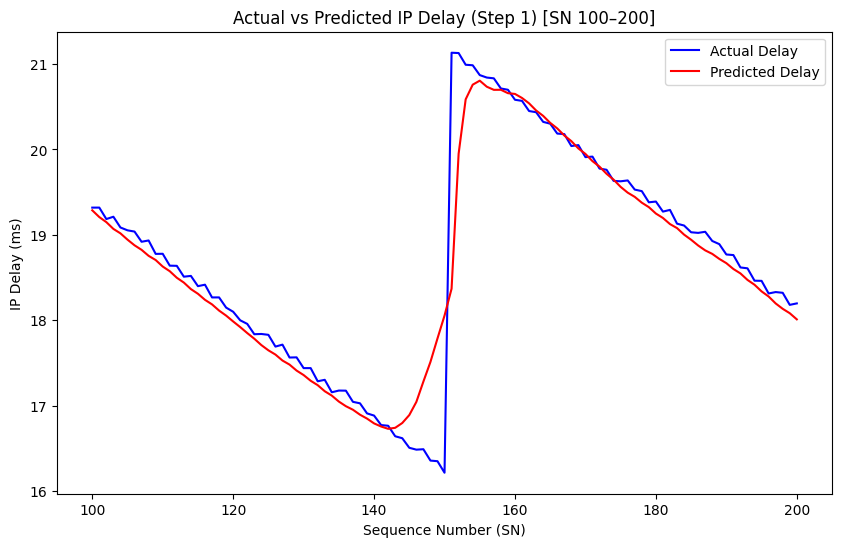

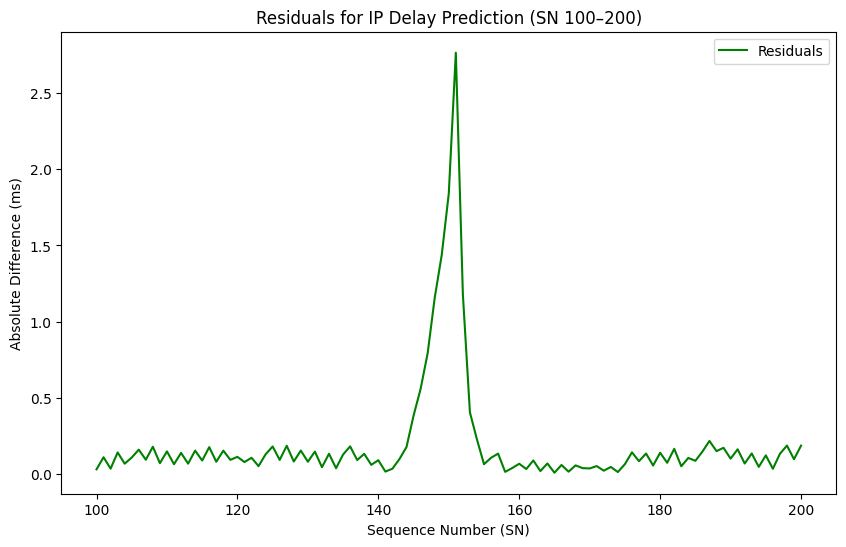

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load dataset
train_data = pd.read_csv('training_1.csv')
test_data = pd.read_csv('testing_1.csv')

# Normalize IP Delay (ms)
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

# Set sequence length and output steps
sequence_length = 10  # Number of input timesteps
output_steps = 5      # Number of output timesteps

# Extract normalized values
train_values = train_data['Normalized IP Delay'].values
test_values = test_data['Normalized IP Delay'].values

# Function to create sequences
def create_seq2seq_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

# Prepare training and test data
X_train, y_train = create_seq2seq_sequences(train_values, sequence_length, output_steps)
X_test, y_test = create_seq2seq_sequences(test_values, sequence_length, output_steps)

# Reshape inputs for RNN [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Reshape outputs [samples, output_steps]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

# Build model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(output_steps)
])

model.compile(optimizer=Adam(0.01), loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict
predictions = model.predict(X_test)

# Denormalize predictions and ground truth
denormalized_predictions = scaler.inverse_transform(predictions)
denormalized_actual = scaler.inverse_transform(y_test)

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN 100 to 200
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 100) & (comparison_df['SN'] <= 200)]

#  Print filtered DataFrame
print(comparison_df_filtered)

#  Plot actual vs predicted (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay (Step 1) [SN 100–200]')
plt.legend()
plt.show()

#  Plot residuals (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals', color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction (SN 100–200)')
plt.legend()
plt.show()
